Notebook purpose

- Explore entropy scores

In [4]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
from entropy import config
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr
import entropy.figures.figures as figs

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
SAMPLE = '777'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
df.head(2)

,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,latest_balance,merchant_business_line,savings,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,entropy_tag_auto,entropy_tag
0,688261,2012-01-03,777,400.00,mdbremoved,NaN,transfers,transfers,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,364.220001,non merchant mbl,False,transfers,other account,other account,u,201201,-1542.99646,24319.220881,7.380999,2.84752
1,688264,2012-01-03,777,10.27,9572 30dec 11 mcdonalds restaurant winwick road gb,mcdonalds,spend,services,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2015-03-19,True,364.220001,mcdonalds,False,dining and drinking,NaN,dining and drinking,u,201201,-1542.99646,24319.220881,7.380999,2.84752


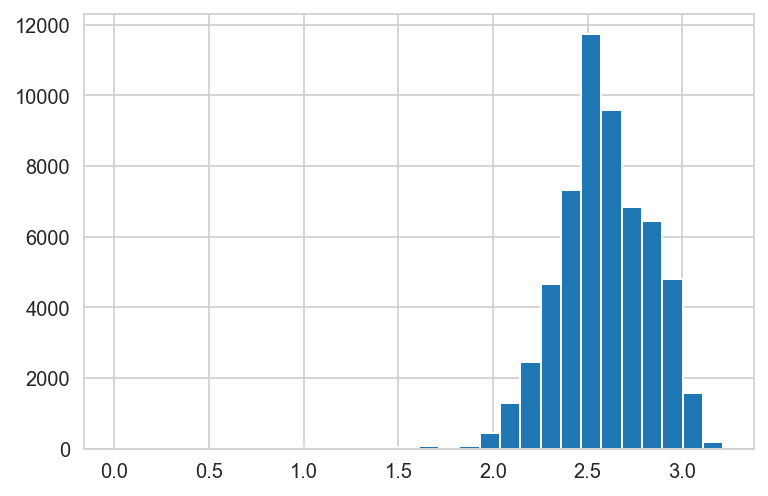

In [32]:
df.entropy_tag.hist(bins=30);

In [ ]:
def entropy(df):
    """Return Shannon Entropy for user and column name."""
    from scipy.stats import entropy

    def calc_entropy(user, num_cats):
        total_txns = len(user)
        txns_by_cat = user.groupby(column).size()
        prop_by_cat = (txns_by_cat + 1) / (total_txns + num_cats)
        return entropy(prop_by_cat, base=2)

    g = df[df.debit].groupby('user_id')
    
    for column in ['tag_auto', 'tag']:
        col_name = '_'.join(['entropy', column])
        num_cats = df[column].nunique()
        
        scores = (g.apply(calc_entropy, num_cats)
                  .rename(col_name)
                  .reset_index())
        df = df.merge(scores, validate='m:1') 

    return df







In [3]:
df.tag.nunique()

15

## User-level entropy

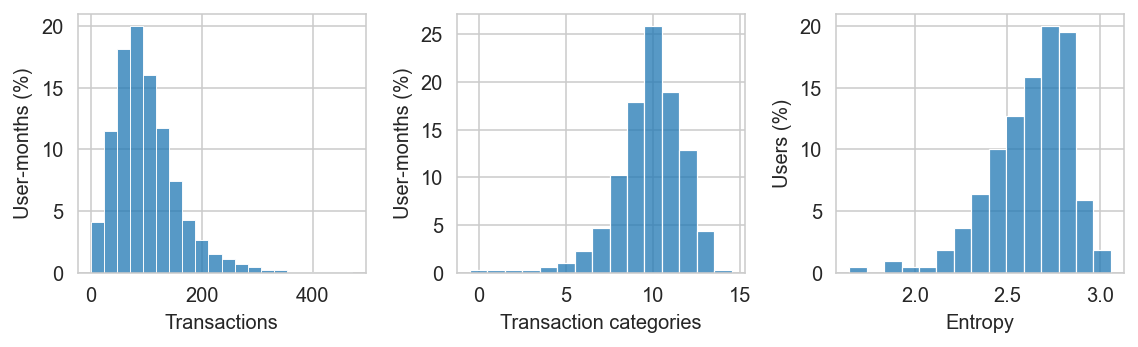

In [176]:
figs.txns_distrs(df, write=False)